---
title: "Digital Twins"
author: Grant and company
date: last-modified
engine: julia
julia:
    exeflags: ["--project=."]
toc: true
toc-depth: 4
toc-expand: 2
toc-title: Outline
toc-location: left
format:
    html:
        linkcolor: black
        theme: cosmo
        lightbox: true
        crossrefs-hover: true
        include-in-header: mathjax.html
        code-overflow: wrap
---

# Digital twins in Julia

In [1]:
Base.active_project()

"/home/gbruer/a/r/JutulJUDIFilter.jl/examples/filter-comparison/Project.toml"

## Get things installed

In [2]:
include("src/install.jl")
include("src/generate_ground_truth.jl")
include("src/plotting_plumes.jl")
include("src/generate_initial_ensemble.jl")
include("src/run_estimator.jl")

## Set params

In [3]:
params = include("params/tutorial-params.jl")
filestem = "tutorial"

"tutorial"

## Run ground-truth

In [4]:
params_gt = params.ground_truth
filestem = "tutorial-ground-truth"

params_file = datadir("ground_truth", "params", "$filestem.jld2")
wsave(params_file; params=params_gt)

params_file = datadir("ground_truth", "params", "$filestem-human.yaml")
YAML.write_file(params_file, to_dict(params_gt, YAMLStyle))

println(YAML.write(to_dict(params_gt, YAMLStyle)))

version: "v0.2"
transition:
  mesh:
    n: (100, 1, 100)
    d: (40, 100.0, 20)
    origin: (0.0, 0.0, 0.0)
  nt: 25
  system:
    viscosity_CO2: 0.0001
    viscosity_H2O: 0.001
    density_CO2: 501.9
    density_H2O: 1053.0
    reference_pressure: 1.5e7
    compressibility_CO2: 8.0e-9
    compressibility_H2O: 3.6563071e-10
    extra_kwargs: NamedTuple()
  dt: 73.0485
  nbatches: 1
  kv_over_kh: 0.36
  sat0_radius_cells: 4
  sat0_range: (0.2, 0.8)
  fluid1:
    name: "H₂O"
    viscosity: 0.001
    density: 1053.0
    compressibility: 3.6563071e-10
  fluid2:
    name: "CO₂"
    viscosity: 0.0001
    density: 776.6
    compressibility: 8.0e-9
  g: 9.81
  reference_pressure: 1.5e7
  porosity:
    name: field
    suboptions:
      value: 0.25
  permeability:
    name: field
    suboptions:
      file: "compass_small/perm_poro.jld2"
      idx: ~
      key: "K"
      scale: 9.86923266716013e-16
      resize: true
  permeability_v_over_h: 0.36
  temperature:
    name: field
    suboptions:
  

In [5]:
savedir = datadir("ground_truth", "data")
data_gt, filepath = produce_or_load(
    generate_ground_truth,
    params_gt,
    savedir;
    filename=filestem,
    verbose=false,
    force=true,
)
states = data_gt["states"]
observations = data_gt["observations"]
observations_clean = data_gt["observations_clean"]
state_times = data_gt["state_times"]
observation_times = data_gt["observation_times"];

╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │  1 steps │ 11 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │     54.0 │      4.90909 │   54 (0) │
│ Linearization  │     65.0 │      5.90909 │   65 (0) │
│ Linear solver  │    140.0 │      12.7273 │  140 (0) │
│ Precond apply  │    280.0 │      25.4545 │  280 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬──────────┬────────────┬────────╮
│ Timing type   │     Each │   Relative │  Total │
│               │       ms │ Percentage │      s │
├───────────────┼──────────┼────────────┼────────┤
│ Properties    │   0.8227 │     0.59 % │ 0.0444 │
│ Equations     │  31.4125 │    26.98 % │ 2.0418 │
│ Assembly      │  13.0973 │    11.25 % │ 0.8513 │
│ Linear solve  │   8.8625 │     6.32 % │ 0.4786 │
│ Linear setup  │  28.8724 │    20.60 % │ 1.5591 │
│ Precond apply │   1.3654 │     5.05

In [6]:
@show length(states)
@show length(state_times)
@show keys(states[1])
@show keys(observations[1])
@show length(observations)
@show length(observation_times);

length(states) = 6
length(state_times) = 6
keys(states[1]) = [:Permeability, :Injector_Pressure, :Saturation, :Pressure, :Facility_TotalSurfaceMassRate, :Injector_Saturations]
keys(observations[1]) = [:dshot, :rtm]
length(observations) = 5
length(observation_times) = 5


In [7]:
CairoMakie.activate!()
grid_2d = get_2d_plotting_mesh(params_gt.transition.mesh)

MeshOptions((100, 100), (0.04, 0.02), (0.0, 0.0))

size(data) = (3, 10000)


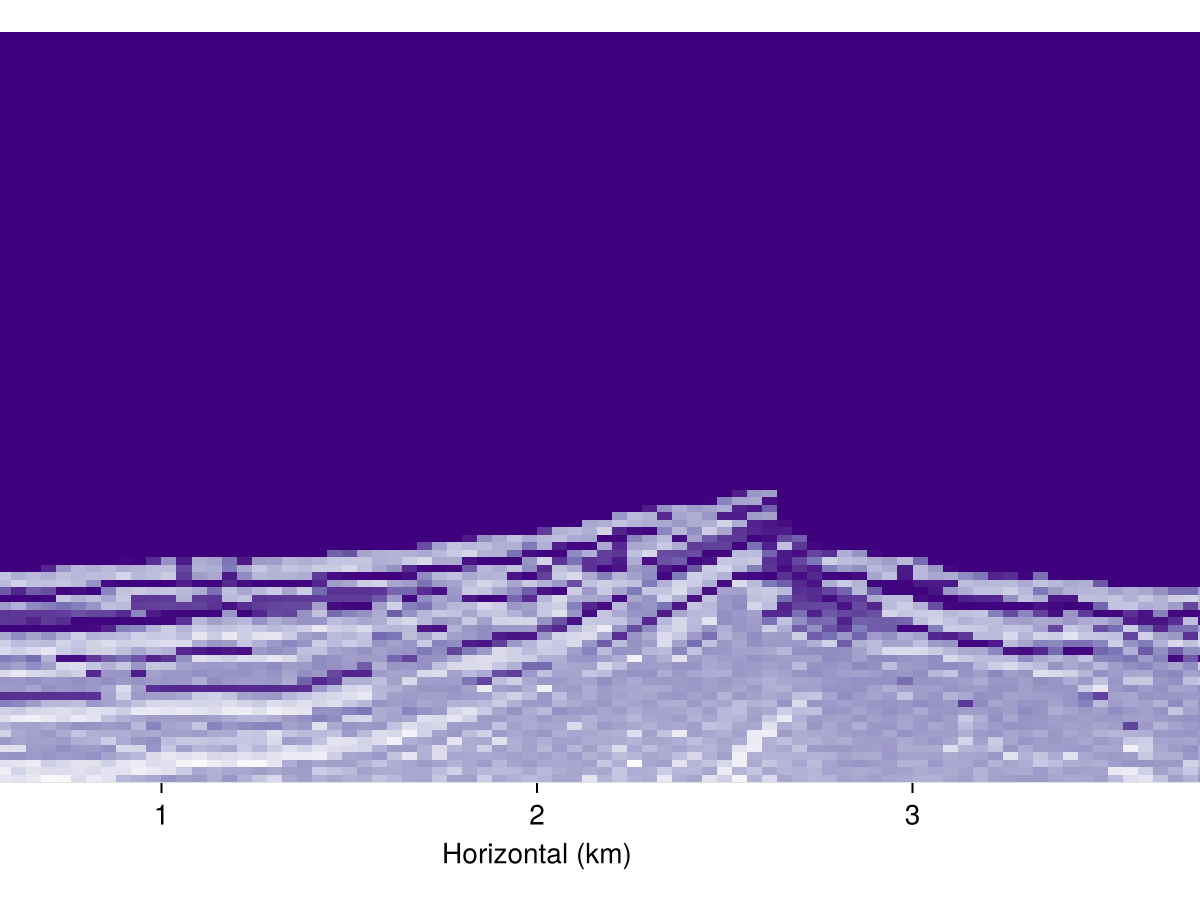

In [8]:
fig = Figure()
data = states[1][:Permeability]
@show size(data)
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, Observable(data[1, :]); grid_2d, heatmap_kwargs=(; colormap=Reverse(:Purples)))
fig

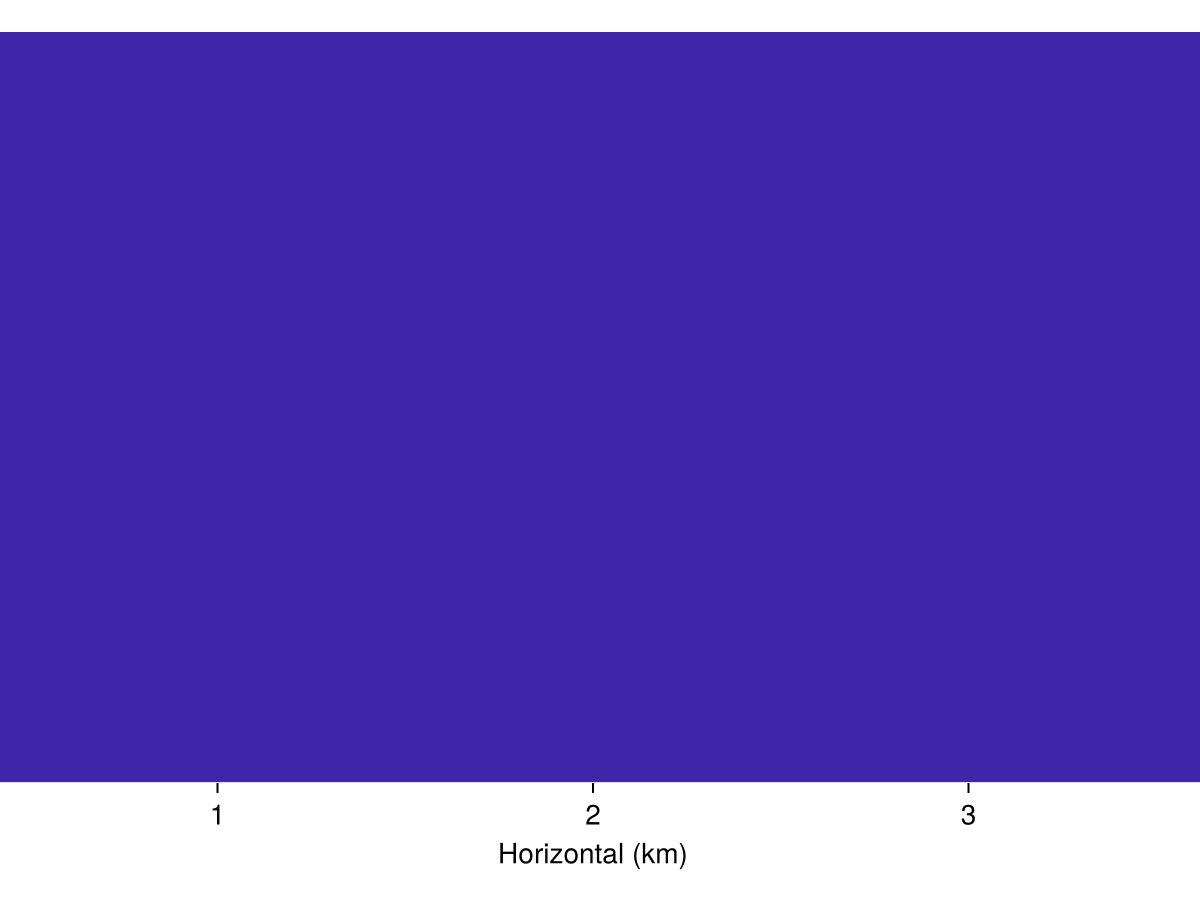

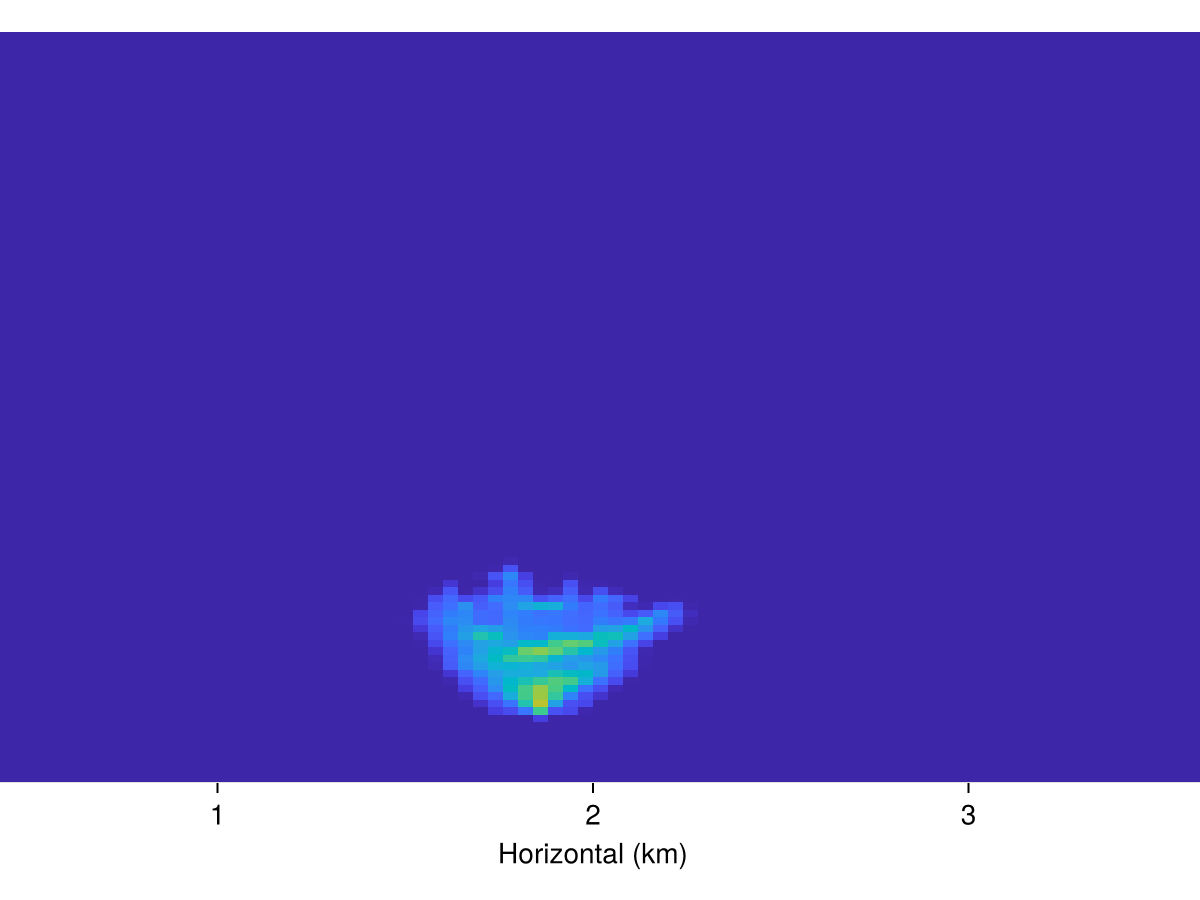

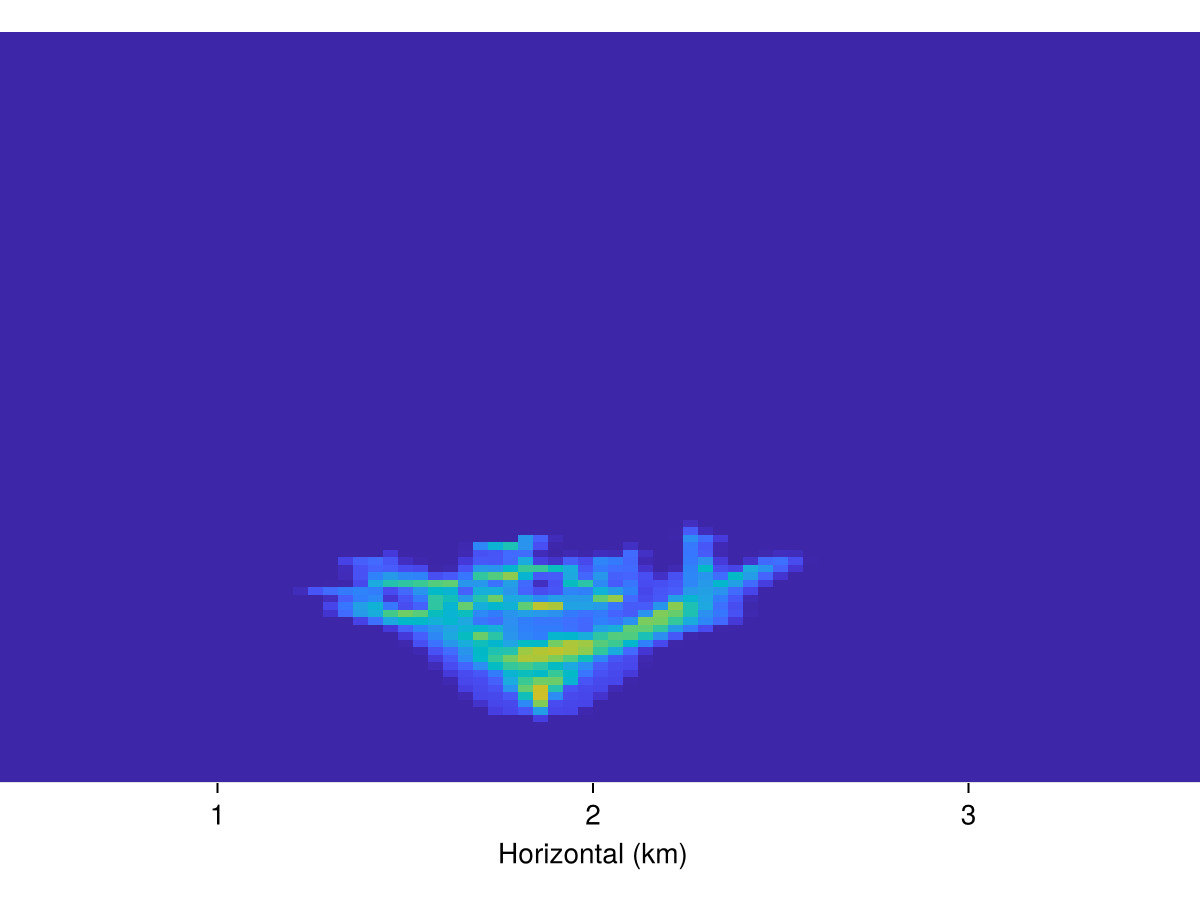

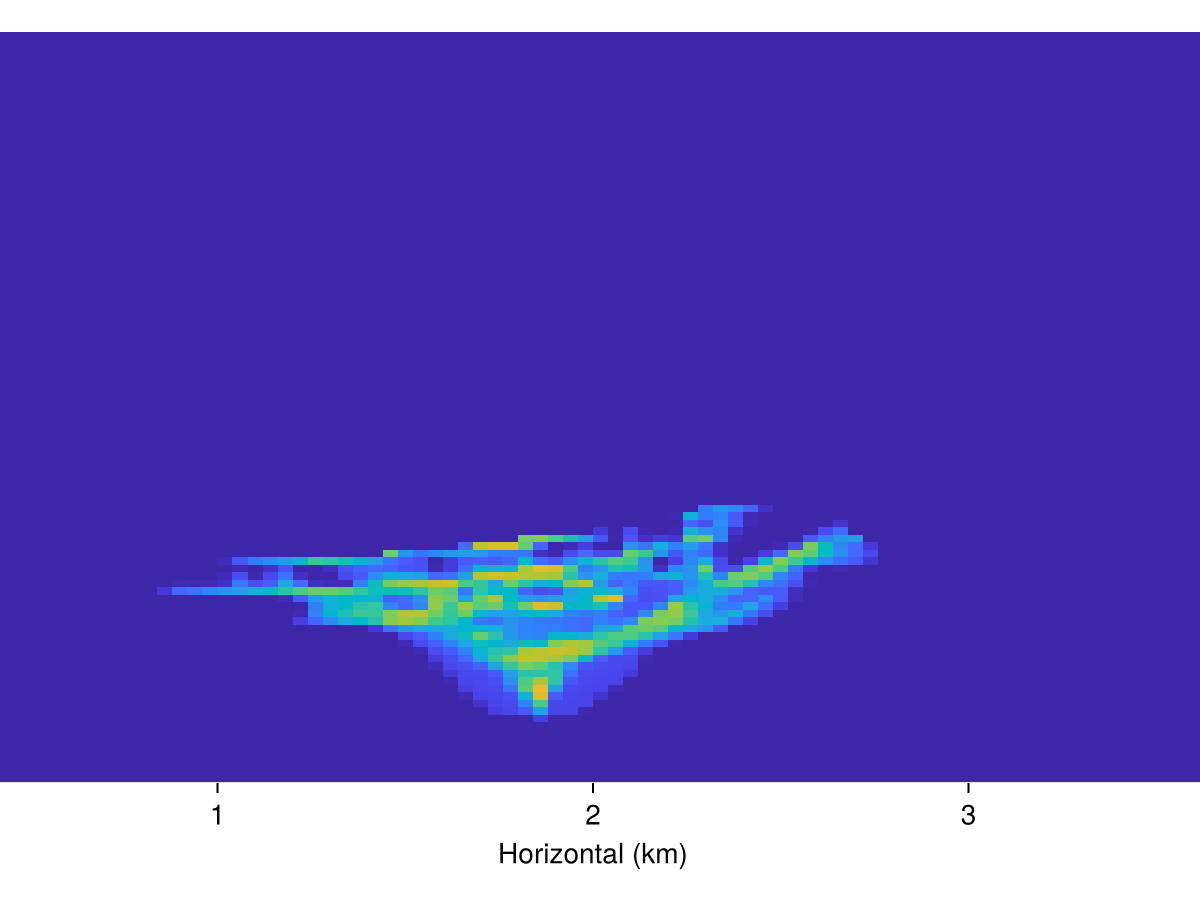

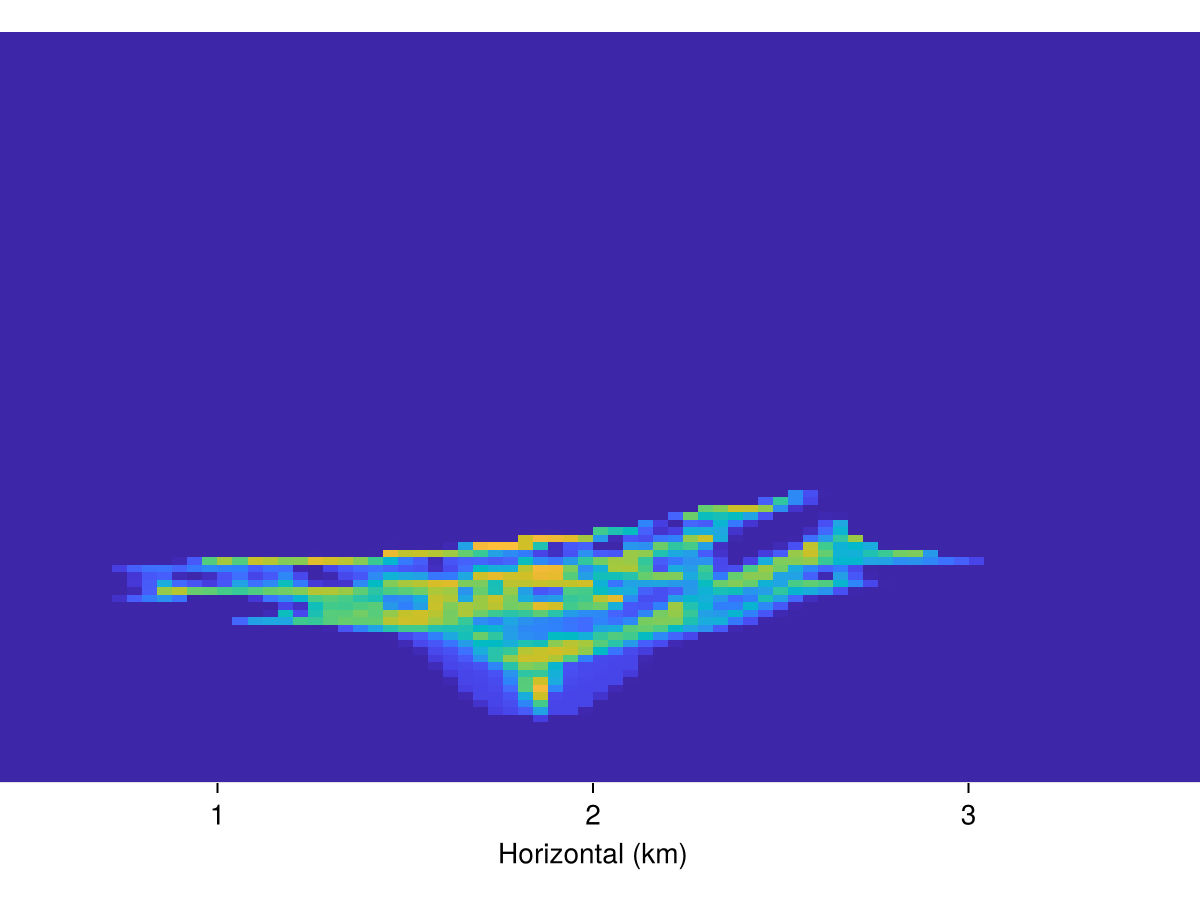

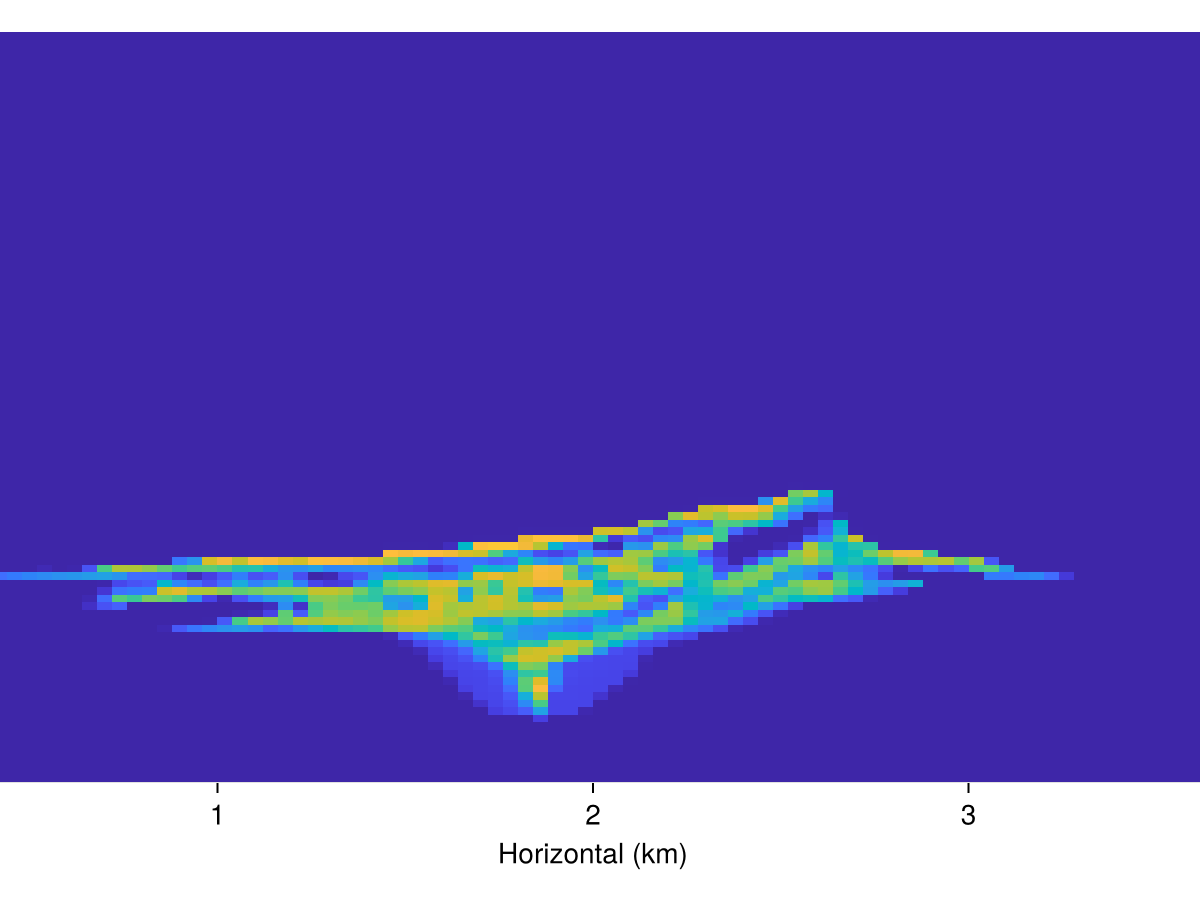

In [9]:
fig = Figure()
t_idx = Observable(1)
data = @lift(states[$t_idx][:Saturation])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colorrange=(0,1), colormap=parula))
for i = 1:length(states)
    t_idx[] = i
    display(fig)
end

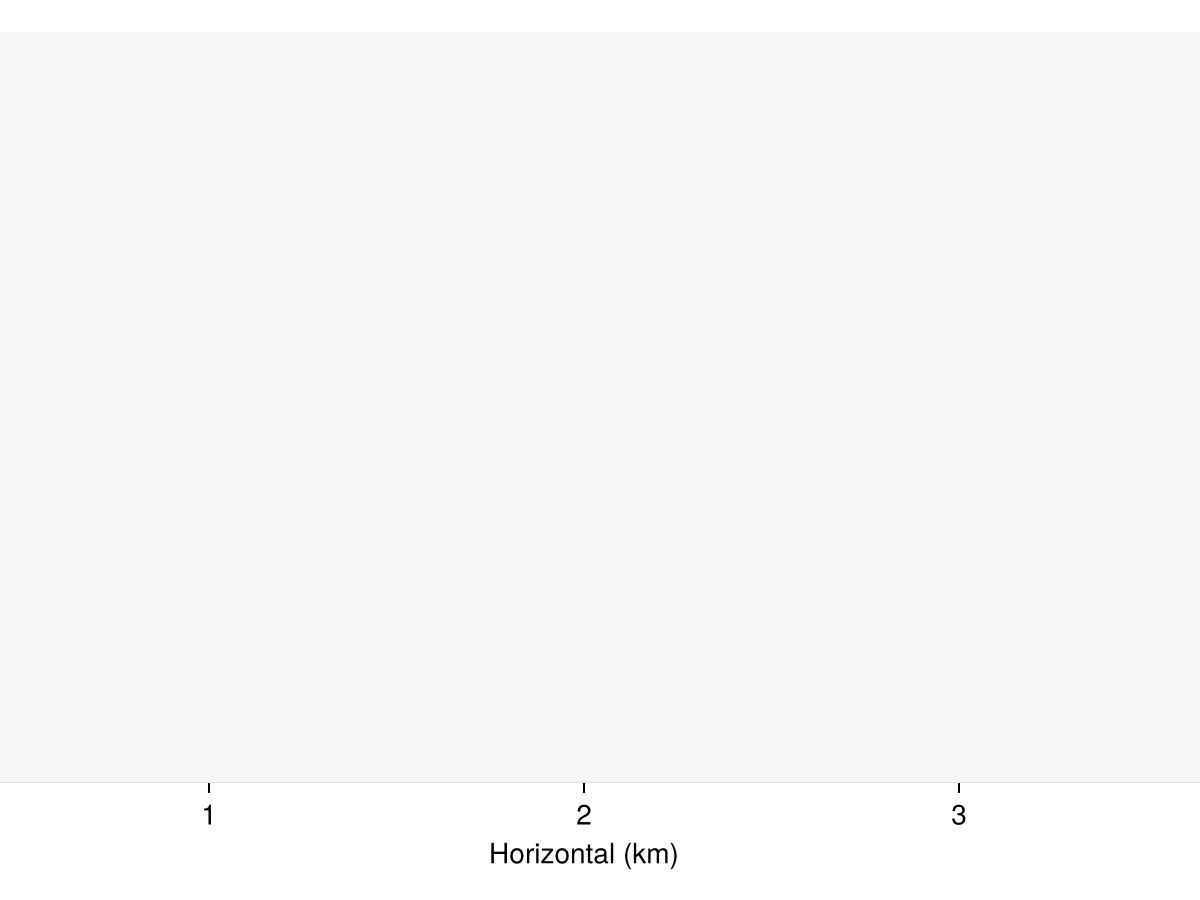

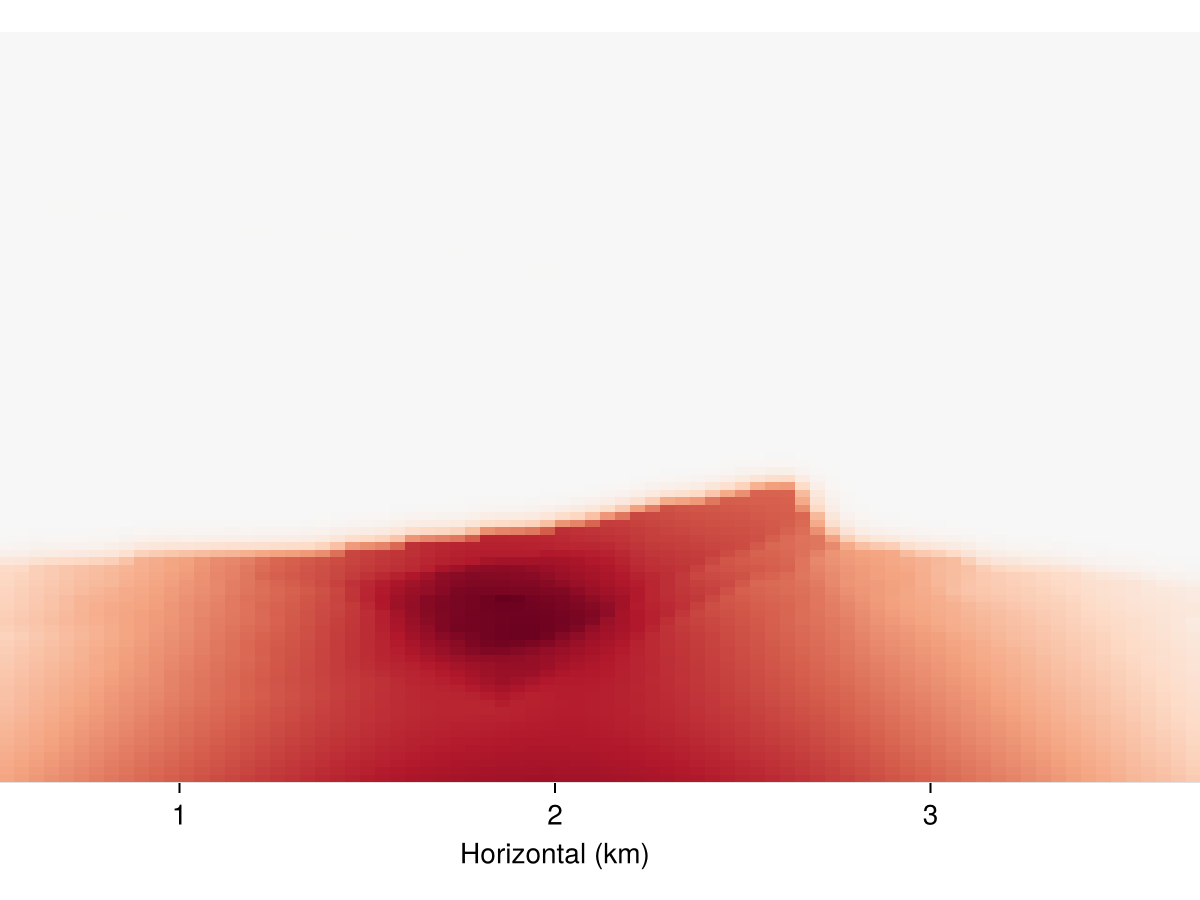

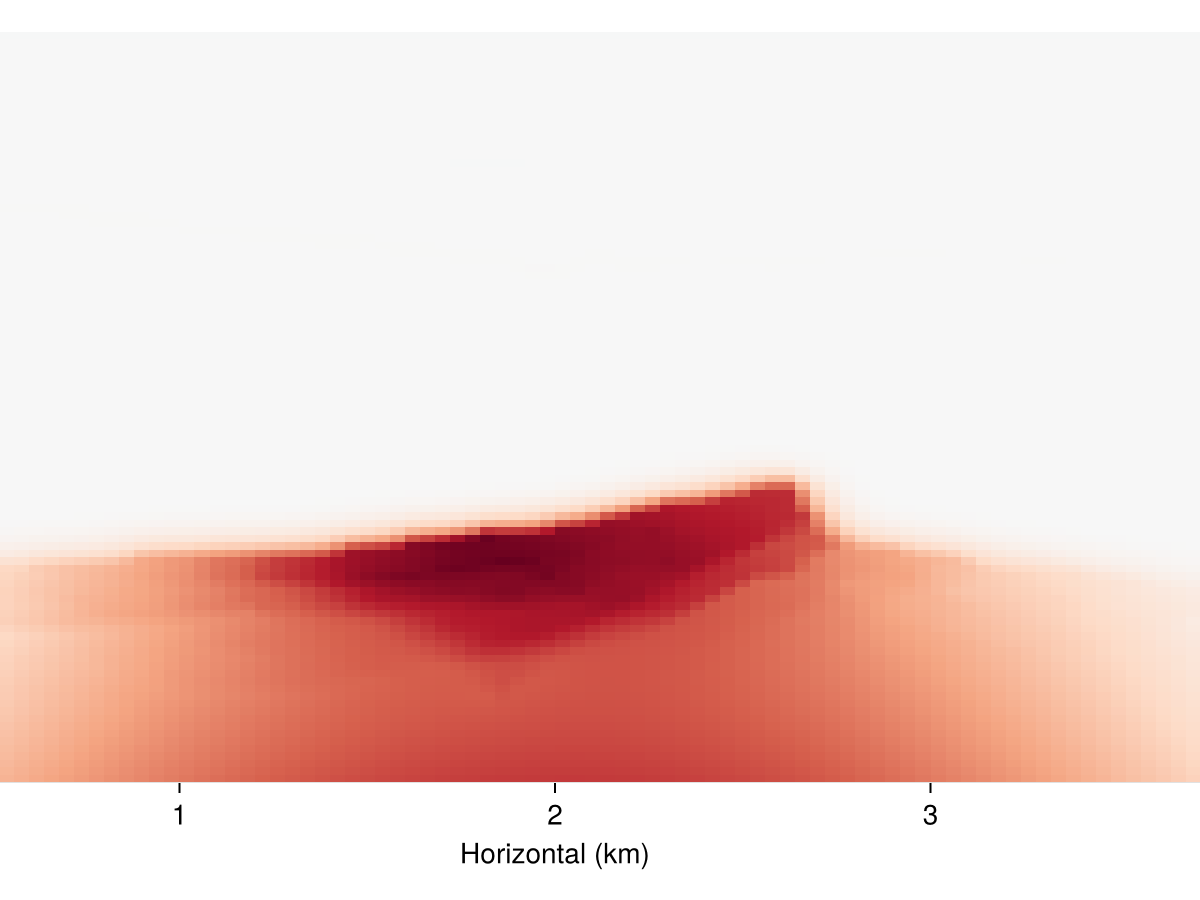

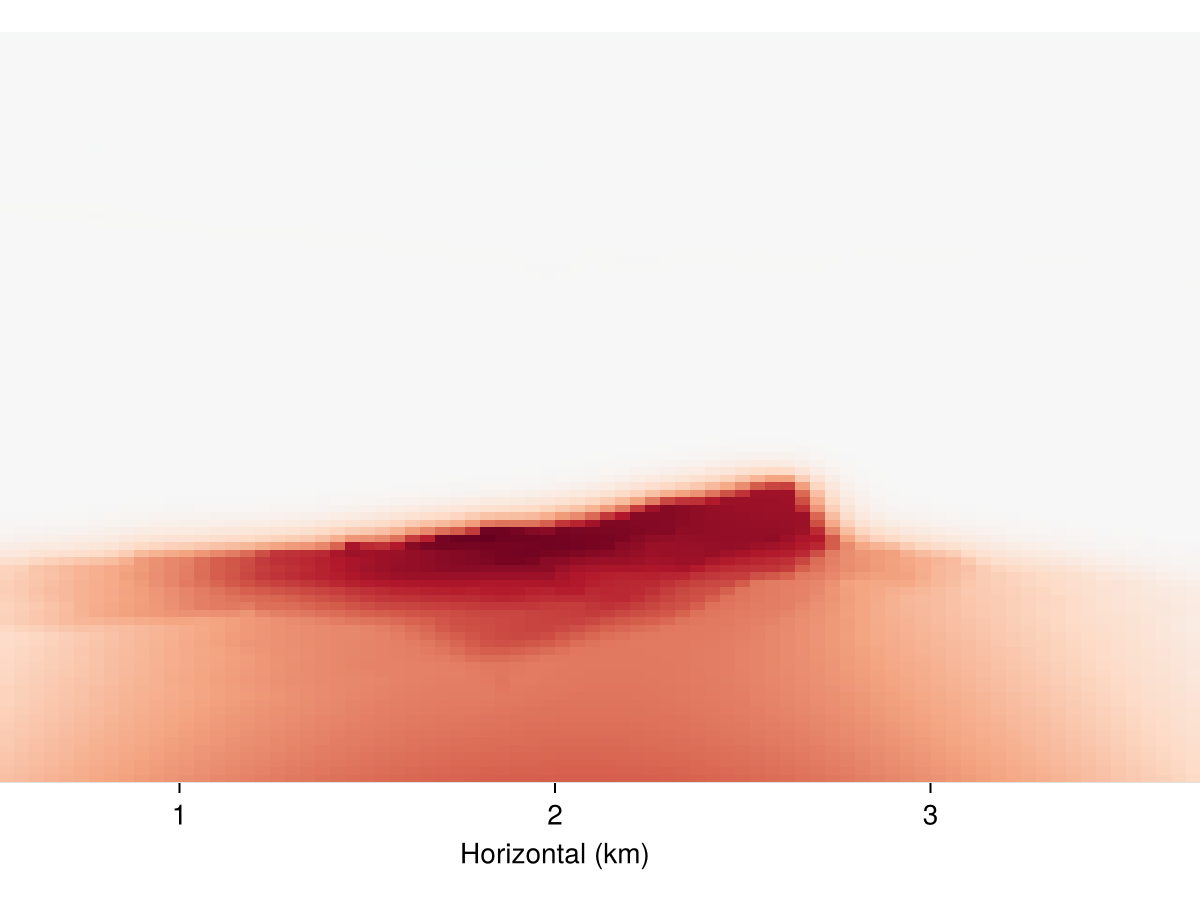

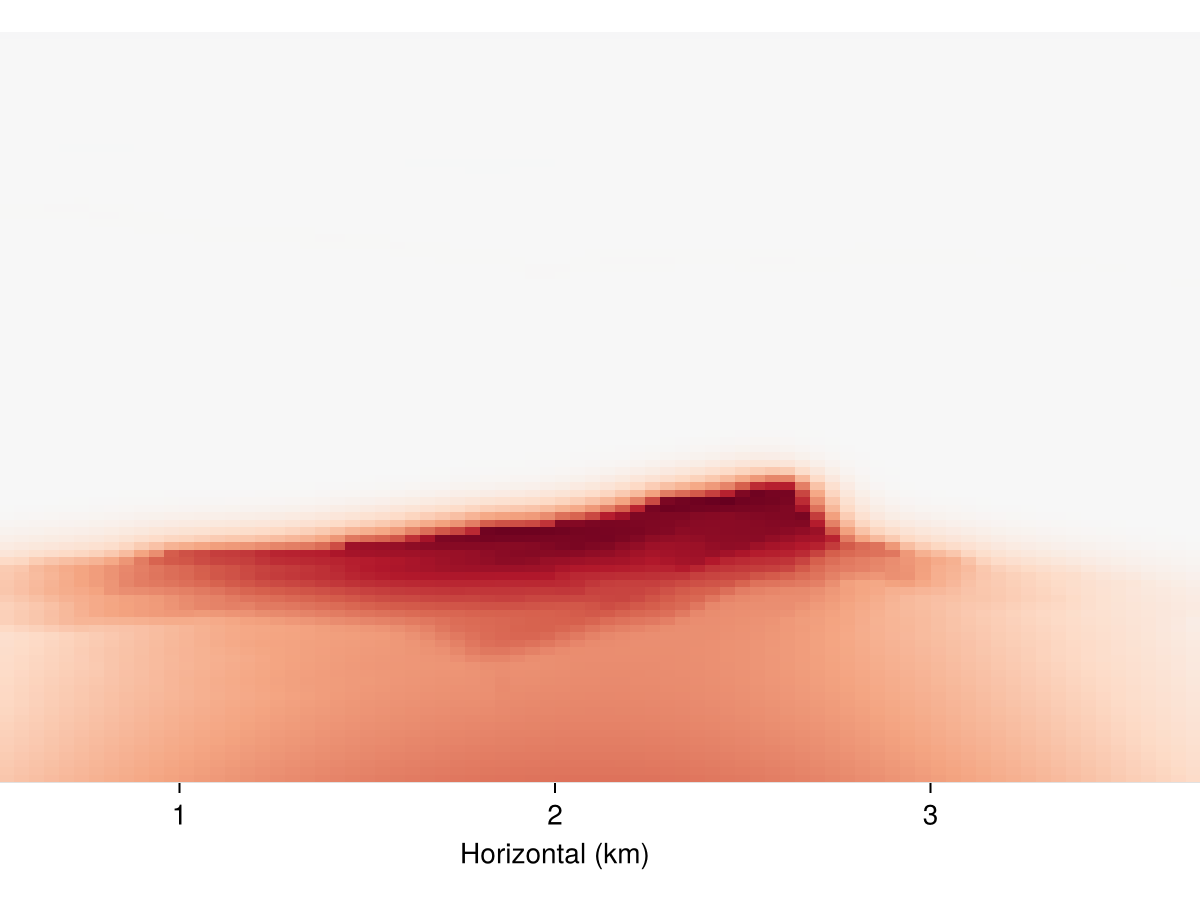

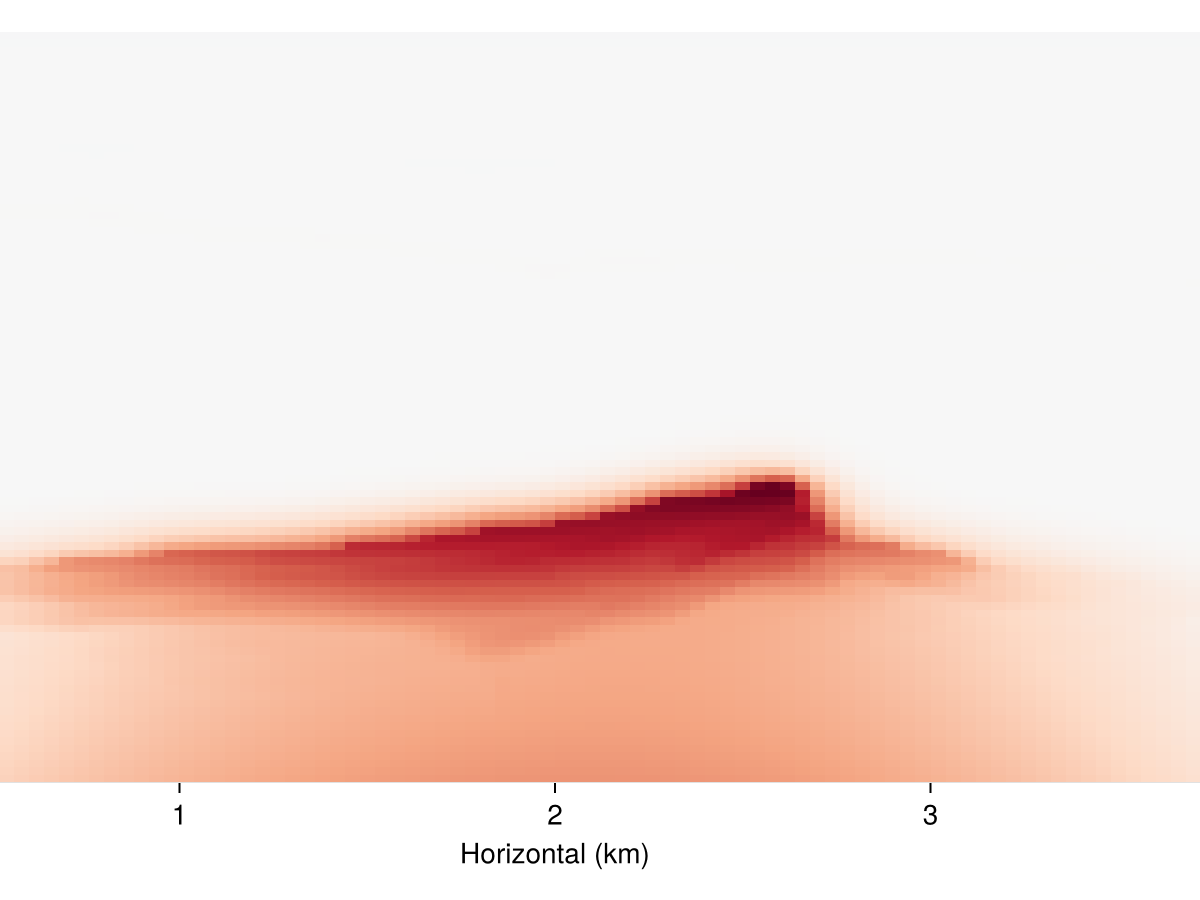

In [10]:
fig = Figure()
t_idx = Observable(1)
data = @lift(states[$t_idx][:Pressure] .- states[1][:Pressure])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; make_divergent=true, colormap=Reverse(:RdBu)))
for i = 1:length(states)
    t_idx[] = i
    display(fig)
end

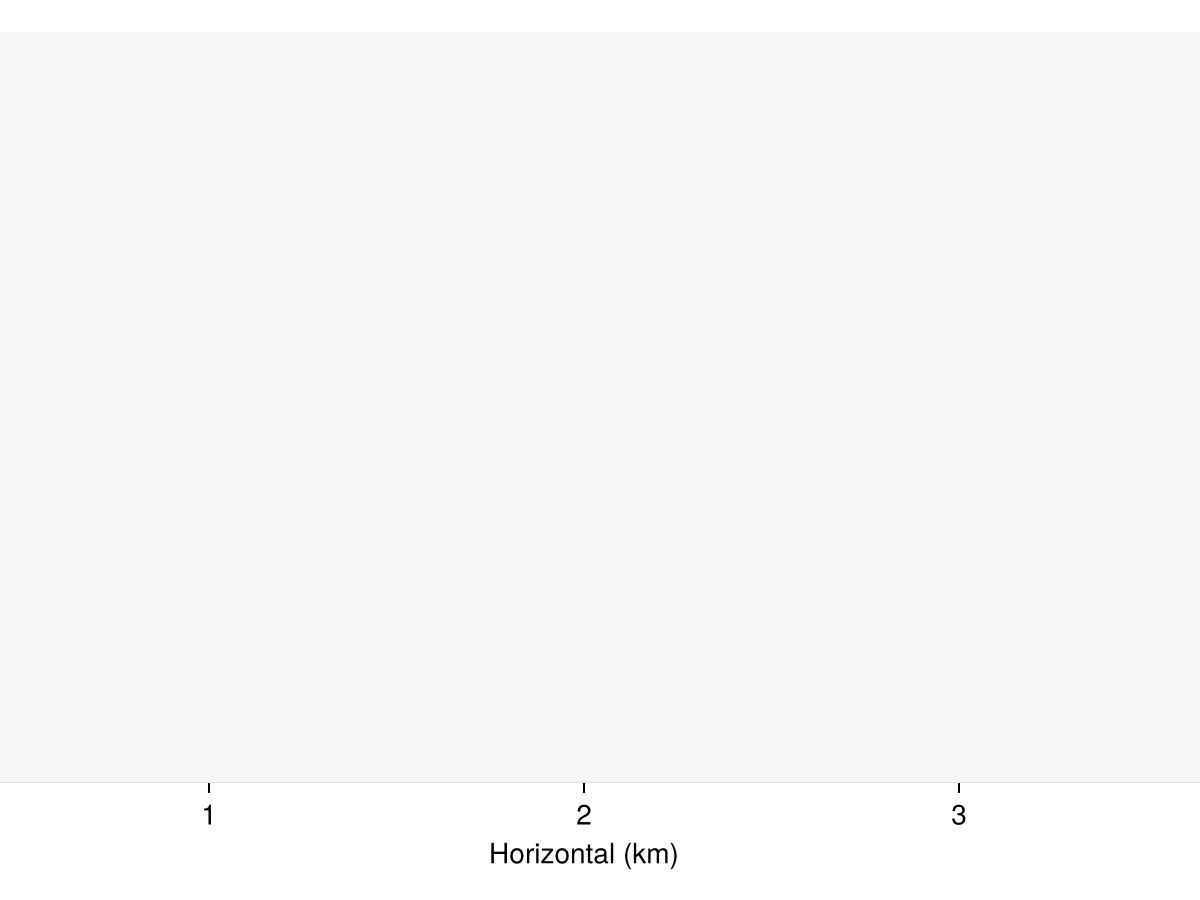

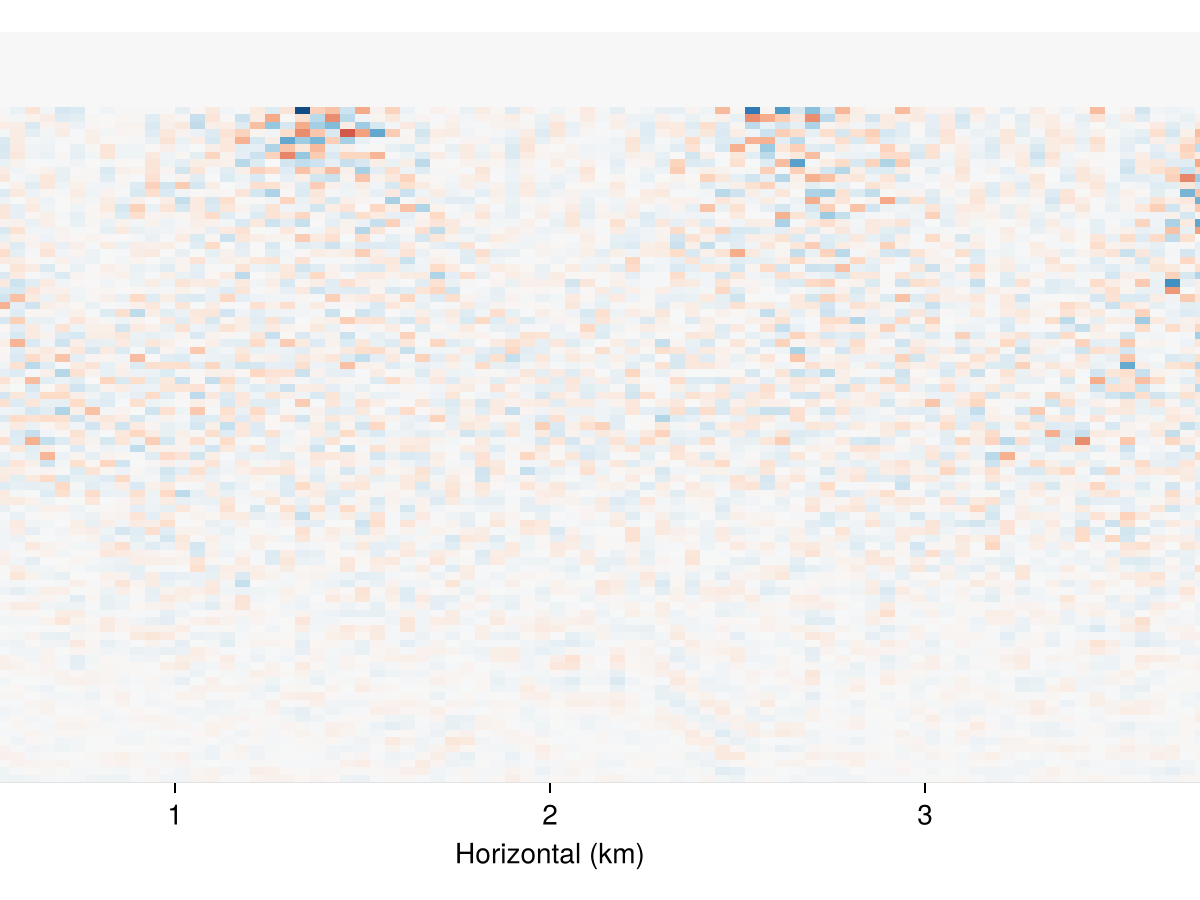

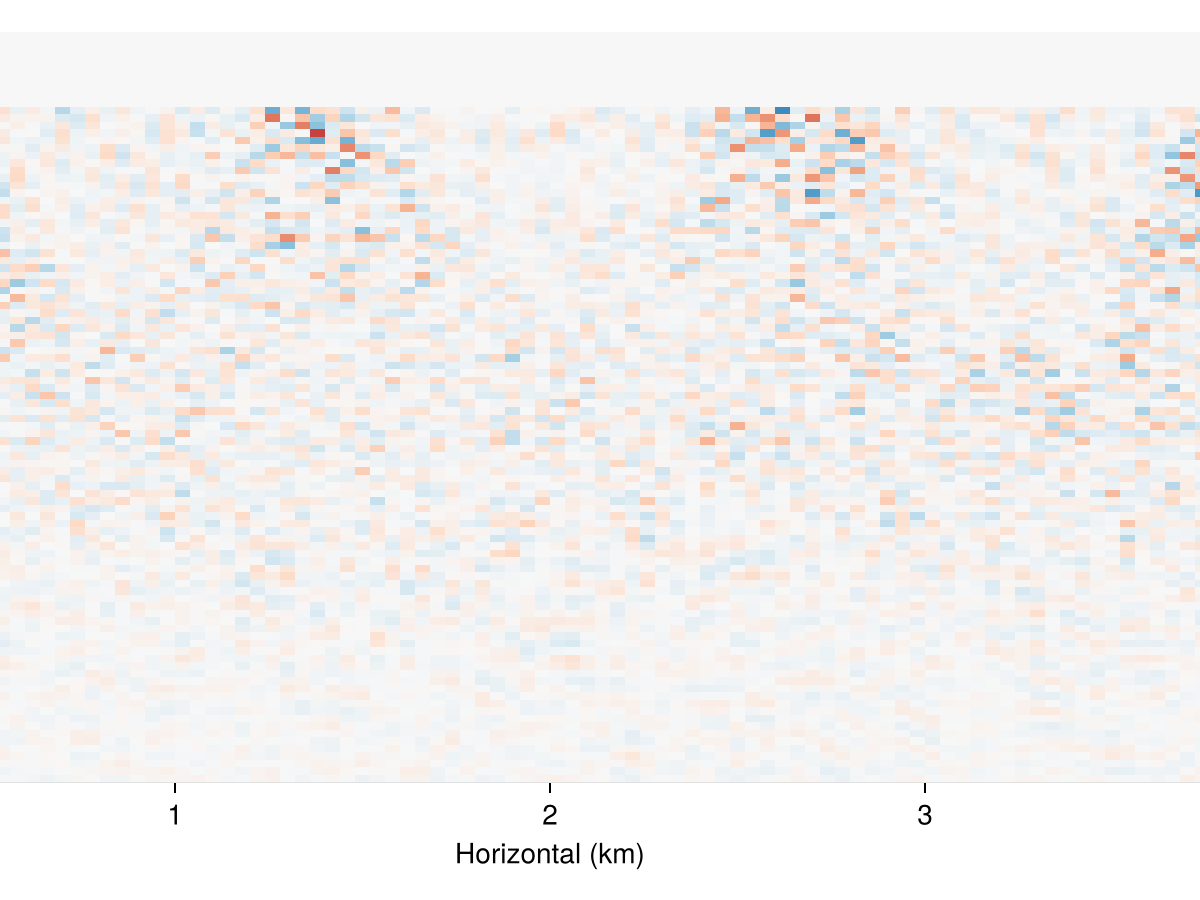

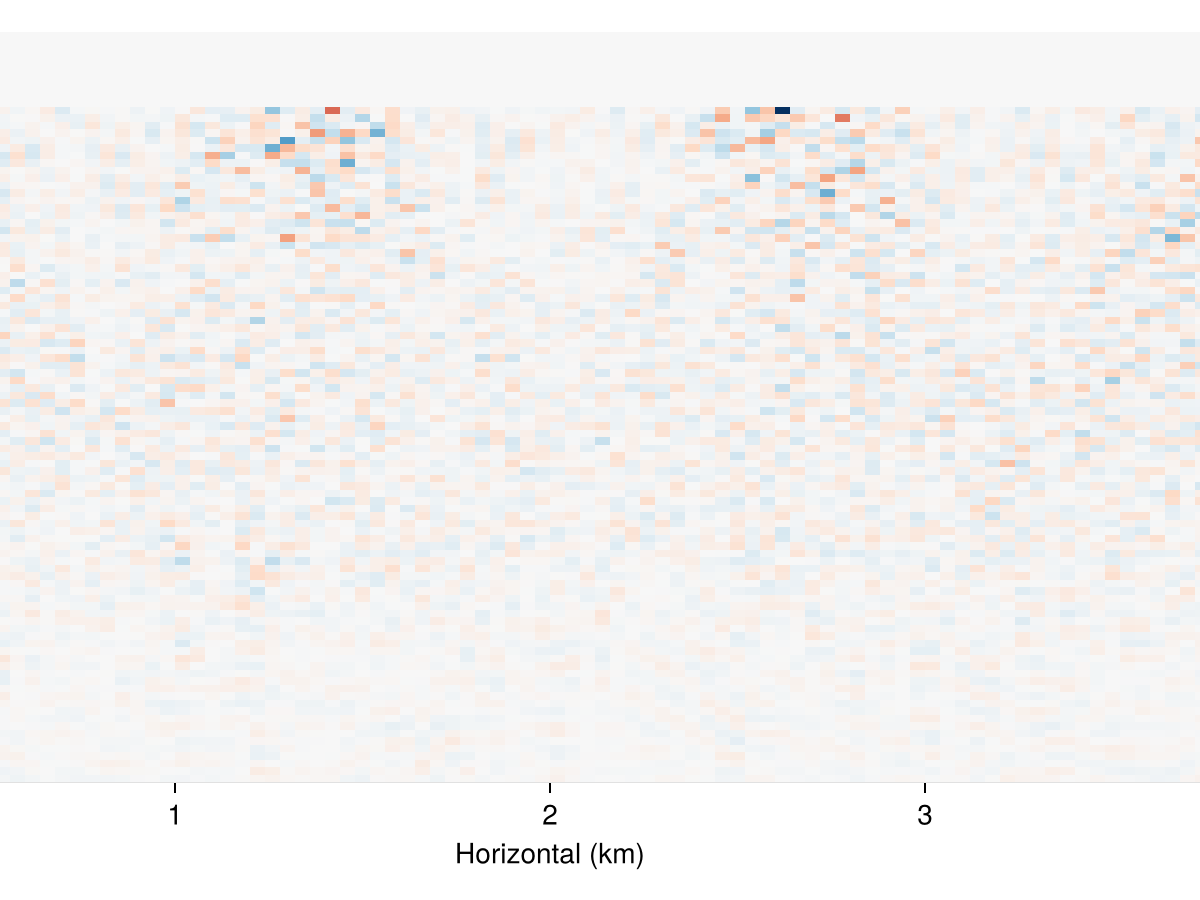

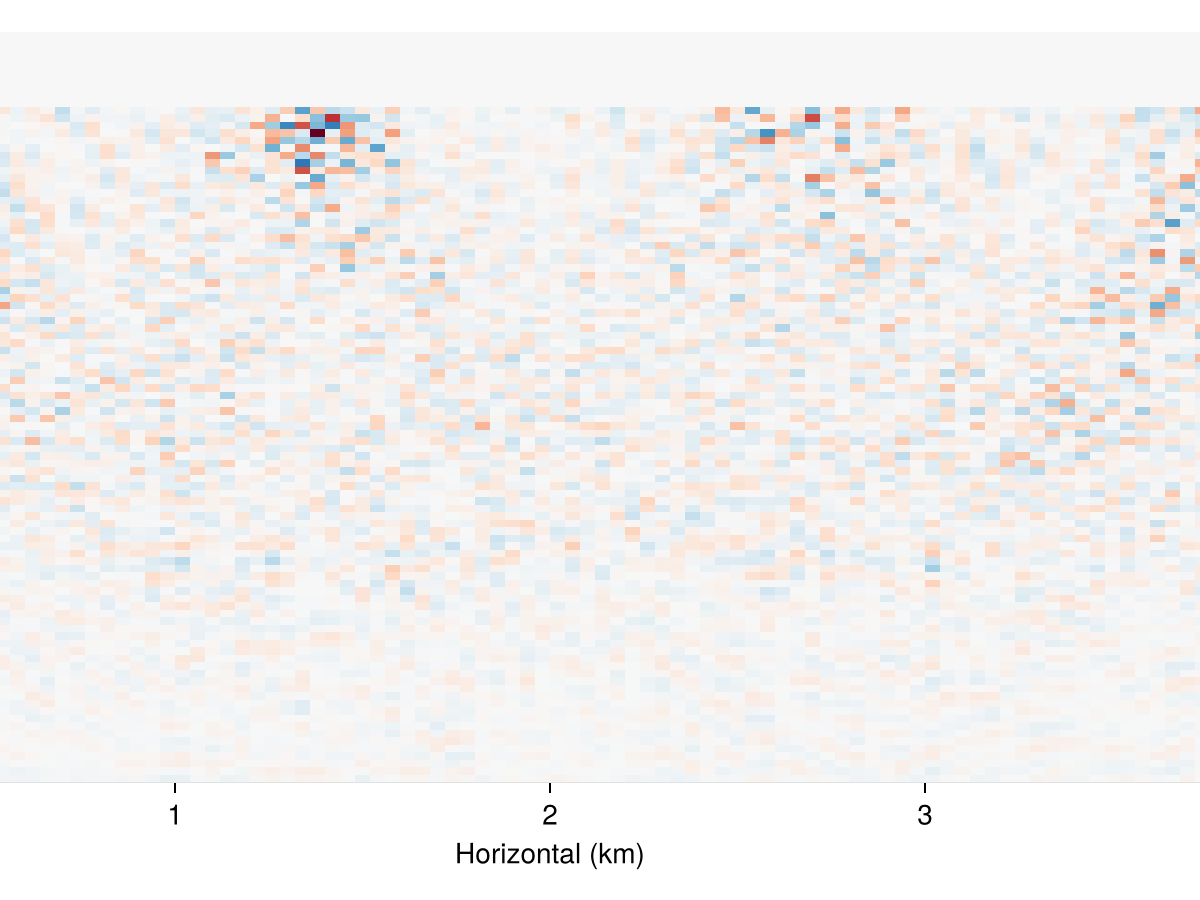

In [11]:
fig = Figure()
t_idx = Observable(1)
data = @lift(observations[$t_idx][:rtm] .- observations[1][:rtm])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; make_divergent=true, colormap=Reverse(:RdBu)))
for i = 1:length(observations)
    t_idx[] = i
    display(fig)
end

src_range = 1:1:4
Plotting source 1 at CartesianIndex(1, 1)
Plotting source 2 at CartesianIndex(2, 1)
Plotting source 3 at CartesianIndex(3, 1)
Plotting source 4 at CartesianIndex(4, 1)


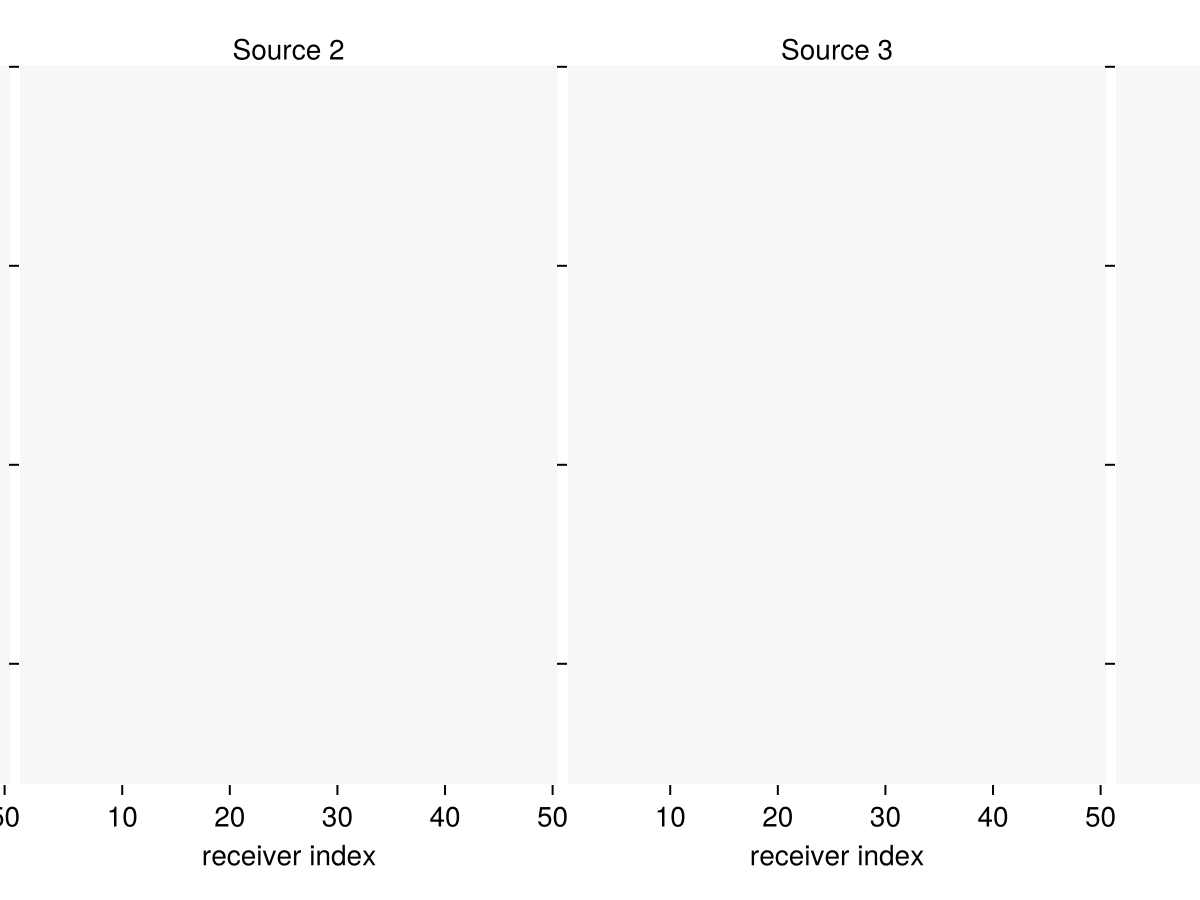

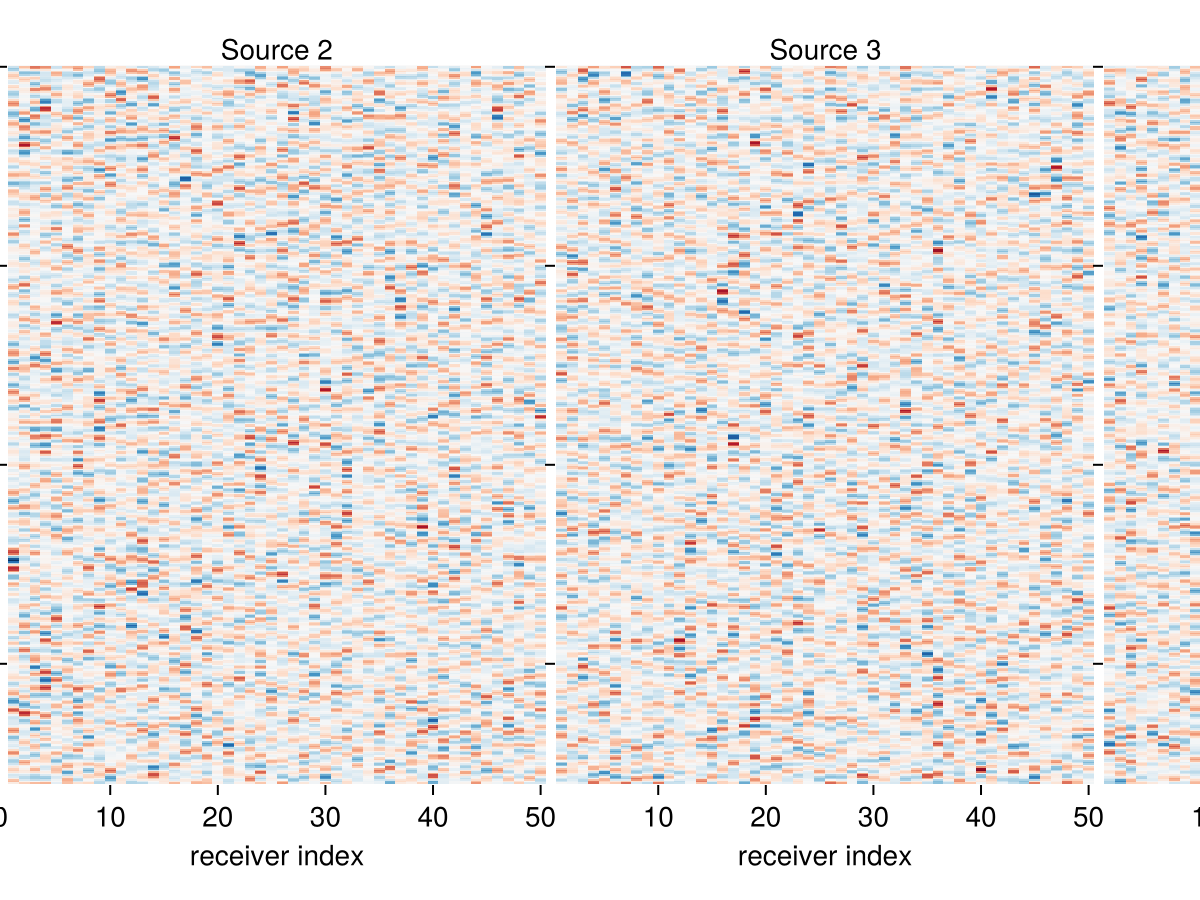

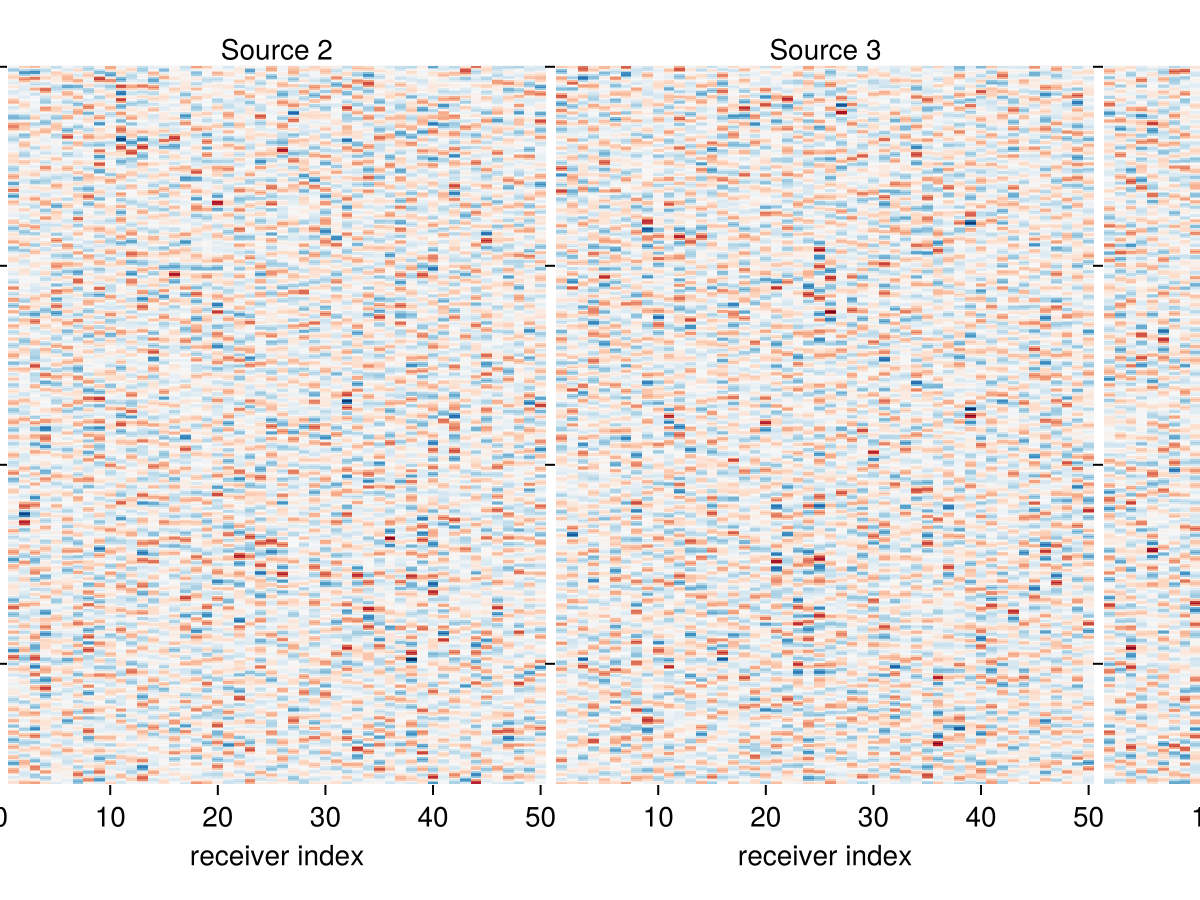

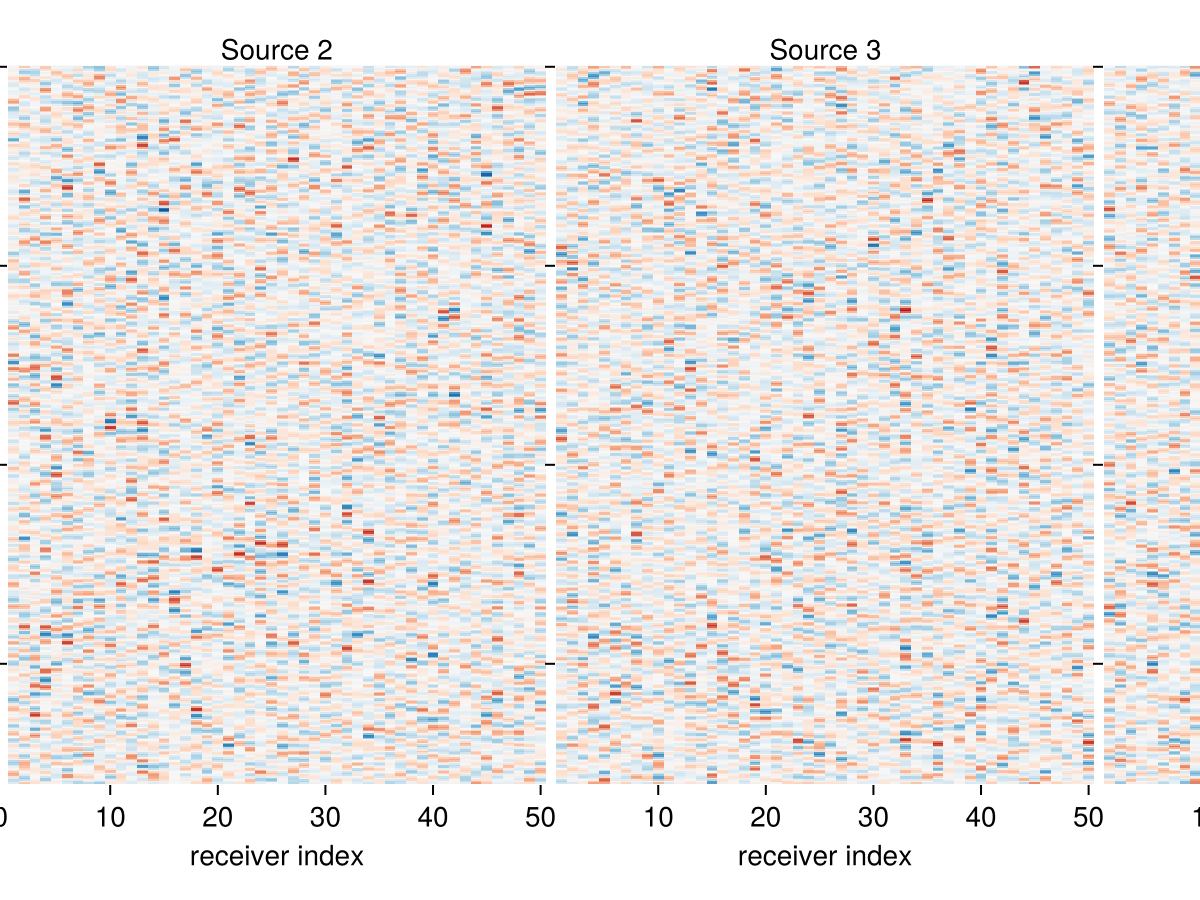

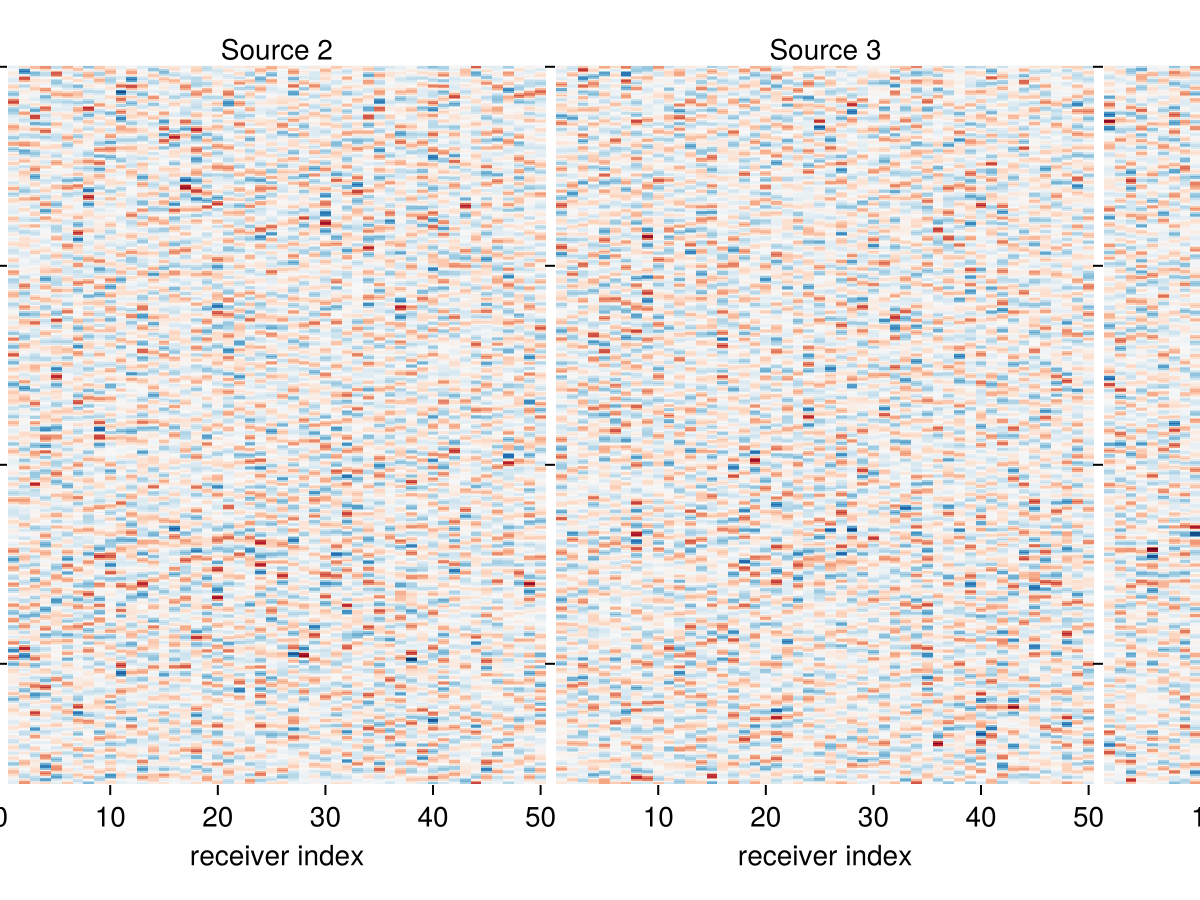

In [12]:
fig = Figure()
t_idx = Observable(1)
function dshot_diff(state)
    return [d .- d0 for (d0, d) in zip(observations[1][:dshot], state[:dshot])]
end
data = @lift(dshot_diff(observations[$t_idx]))
content_layout = GridLayout(fig[1,1])
timeR = @lift(params_gt.observation.observers[$t_idx].second.seismic.timeR)
dtR = @lift(params_gt.observation.observers[$t_idx].second.seismic.dtR)
nsrc = params_gt.observation.observers[1].second.seismic.source_receiver_geometry.nsrc
plot_data(content_layout, data, nothing, :dshot; heatmap_kwargs=(; make_divergent=true, colormap=Reverse(:RdBu)), nsrc, timeR, dtR)
for i = 1:length(observations)
    t_idx[] = i
    display(fig)
end

## Create initial ensemble.


In [13]:
filestem = "tutorial-initial-ensemble"

params_file = datadir("initial_ensemble", "params", "$filestem.jld2")
wsave(params_file; params=params.ensemble)

params_file = datadir("initial_ensemble", "params", "$filestem-human.yaml")
YAML.write_file(params_file, to_dict(params.ensemble, YAMLStyle))

println(YAML.write(to_dict(params.ensemble, YAMLStyle)))

version: "v0.1"
size: 2
seed: 9347215
mesh:
  n: (100, 1, 100)
  d: (40, 100.0, 20)
  origin: (0.0, 0.0, 0.0)
permeability_v_over_h: 0.36
prior: (Saturation = GaussianPriorOptions(0, 0), Permeability = FieldOptions(:field, FieldFileOptions("compass_small/perm_poro.jld2", nothing, "Ks", 9.86923266716013e-16, true)))



In [14]:
savedir = datadir("initial_ensemble", "data")
data_initial, filepath = produce_or_load(
    generate_initial_ensemble,
    params.ensemble,
    savedir;
    filename=filestem,
    verbose=false,
    loadfile=true,
)
ensemble = data_initial["ensemble"];

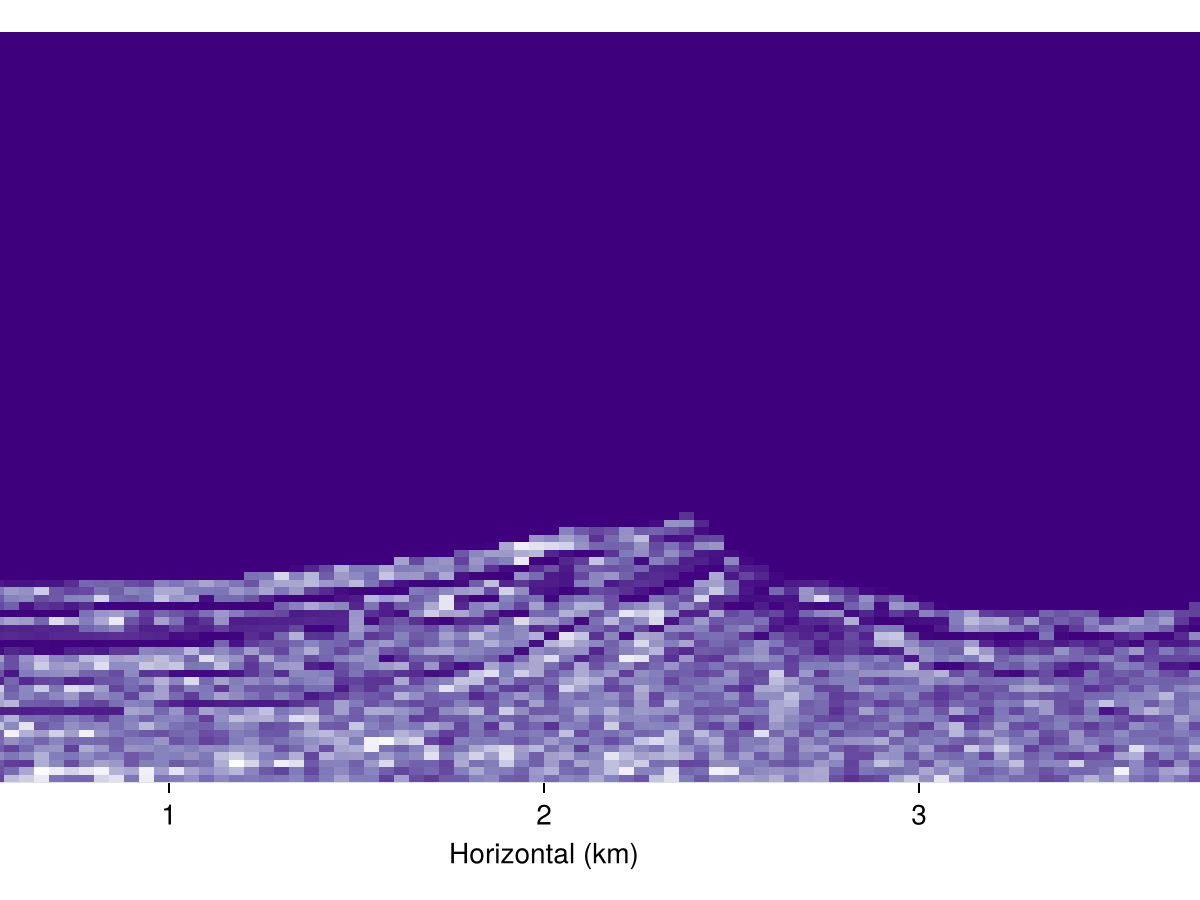

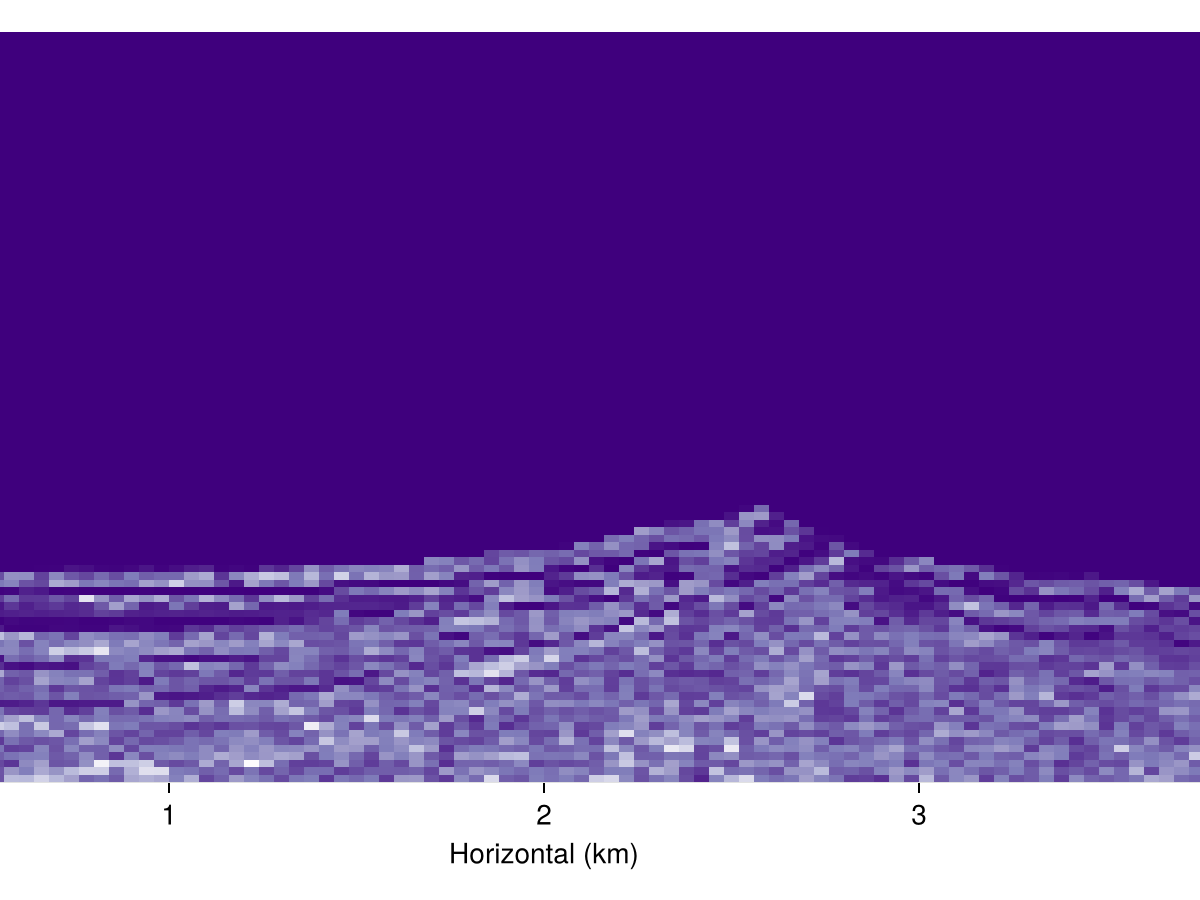

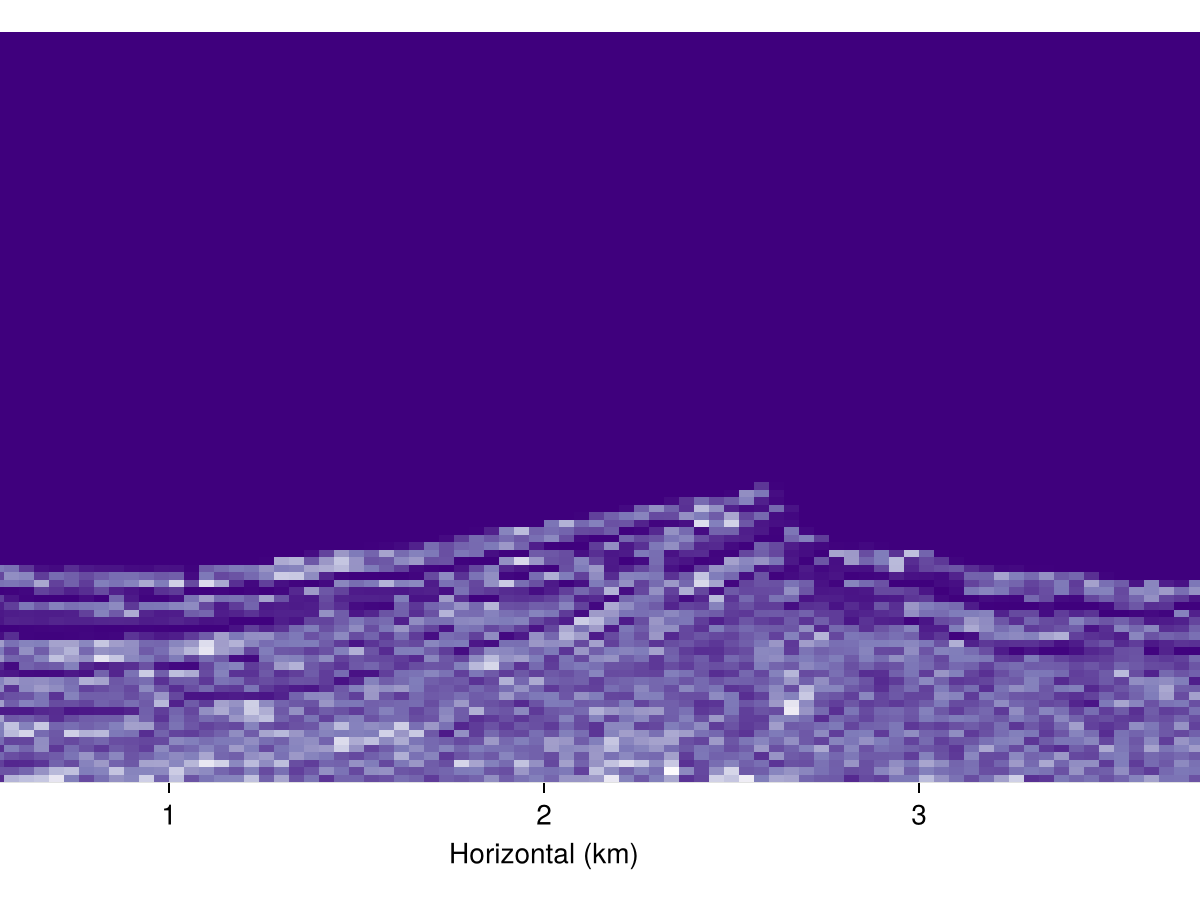

In [15]:
fig = Figure()
e_idx = Observable(1)
data = @lift(ensemble.members[$e_idx][:Permeability][1, :])
content_layout = GridLayout(fig[1,1])
plot_scalar_field(content_layout, data; grid_2d, heatmap_kwargs=(; colormap=Reverse(:Purples)))
for i = 1:min(length(ensemble.members), 3)
    e_idx[] = i
    display(fig)
end

## Run estimator


In [16]:
filestem = "tutorial-estimator"

params_file = datadir("estimator", "params", "$filestem.jld2")
wsave(params_file; params=params.estimator)

params_file = datadir("estimator", "params", "$filestem-human.yaml")
YAML.write_file(params_file, to_dict(params.ensemble, YAMLStyle))

println(YAML.write(to_dict(params.ensemble, YAMLStyle)))

version: "v0.1"
size: 2
seed: 9347215
mesh:
  n: (100, 1, 100)
  d: (40, 100.0, 20)
  origin: (0.0, 0.0, 0.0)
permeability_v_over_h: 0.36
prior: (Saturation = GaussianPriorOptions(0, 0), Permeability = FieldOptions(:field, FieldFileOptions("compass_small/perm_poro.jld2", nothing, "Ks", 9.86923266716013e-16, true)))



In [17]:
savedir = datadir("estimator", "data")

states_gt = data_gt["states"]
observations_gt = data_gt["observations"]

ensemble = data_initial["ensemble"]

K = (Val(:Saturation), Val(:Pressure), Val(:Permeability))
JMT = JutulModelTranslator(K)

M = JutulModel(; translator=JMT, options=params.estimator.transition)
observers = get_multi_time_observer(params.estimator.observation)

# Initialize member for all primary variables in simulation.
@progress "Initialize ensemble states" for member in get_ensemble_members(ensemble)
    initialize_member!(M, member)
end

estimator = get_estimator(params.estimator.algorithm)

empty!(ensemble.state_keys)
append!(ensemble.state_keys, params.estimator.assimilation_keys)

t0 = 0.0
data = filter_loop(
    ensemble,
    t0,
    estimator,
    M,
    observers,
    observations_gt;
    name=get_short_name(params.estimator.algorithm),
    max_transition_step = params.estimator.max_transition_step,
)

╭────────────────┬──────────┬──────────────┬──────────╮
│ Iteration type │ Avg/step │ Avg/ministep │    Total │
│                │  1 steps │ 11 ministeps │ (wasted) │
├────────────────┼──────────┼──────────────┼──────────┤
│ Newton         │     54.0 │      4.90909 │   54 (0) │
│ Linearization  │     65.0 │      5.90909 │   65 (0) │
│ Linear solver  │    147.0 │      13.3636 │  147 (0) │
│ Precond apply  │    294.0 │      26.7273 │  294 (0) │
╰────────────────┴──────────┴──────────────┴──────────╯
╭───────────────┬─────────┬────────────┬──────────╮
│ Timing type   │    Each │   Relative │    Total │
│               │      ms │ Percentage │       ms │
├───────────────┼─────────┼────────────┼──────────┤
│ Properties    │  0.8286 │     4.53 % │  44.7460 │
│ Equations     │  2.2096 │    14.54 % │ 143.6263 │
│ Assembly      │  0.8429 │     5.55 % │  54.7898 │
│ Linear solve  │  1.4648 │     8.01 % │  79.0983 │
│ Linear setup  │  6.5909 │    36.02 % │ 355.9083 │
│ Precond apply │  0.9044 │ 

Dict{String, Any} with 11 entries:
  "observations_clean"      => Any[Ensemble(Dict{Symbol, Array}[Dict(:dshot=>Ma…
  "observation_times"       => Any[3.1557e7, 6.31139e7, 9.46709e7, 1.26228e8, 1…
  "observation_clean_means" => Any[Dict{Symbol, Array}(:dshot=>Matrix{Float32}[…
  "observation_means"       => Any[Dict{Symbol, Array}(:rtm_noisy=>Float32[0.0 …
  "states"                  => Any[(ensemble = Ensemble(Dict{Symbol, Any}[Dict(…
  "logs"                    => Any[Dict{Symbol, Any}(:assimilate_data_linear_so…
  "t"                       => 1.57785e8
  "state_means"             => Any[Dict{Symbol, Any}(:Permeability=>[1.30921e-1…
  "observations"            => Any[Ensemble(Dict{Symbol, Array}[Dict(:dshot=>Ma…
  "state_times"             => Any[3.1557e7, 3.1557e7, 6.31139e7, 6.31139e7, 9.…
  "ensemble"                => Ensemble(Dict{Symbol, Any}[Dict(:Permeability=>[…

In [23]:
using JLD2
data2 = Dict(Symbol(k) => v for (k,v) in data)
jldsave(joinpath(savedir, "tutorial-estimator.jld2"); data2...)

## Brief math review

There is an unknown state $x$. We know it changes over time according to a transition operator $\mathcal{M}$.

We can observe $x$ indirectly with an observation observation $y$ from observation model $\mathcal{H}$.

We have a transition operator $\mathcal{M}$ and an observation operator $\mathcal{H}$.


## Operators for geologic CO~2~ storage

### CO~2~ plume physics with Jutul

### Seismic wave physics with JUDI

## Set up synthetic system

### CO~2~ state evolution

```
## states = M()
## Plot states
```

### Seismic observations

Observe a few states.
```
## TODO
```

## Filtering

### Set up ensemble

### Predict without observations

### Assimilation observations

### Repeat

## Analyze results

### Error

### Uncertainty
